In [85]:
import MySQLdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getDBCursor():
  db = MySQLdb.connect(host="flagon.cs.umn.edu",     # your host
                       user="readonly",              # your username
                       passwd="",                    # your password
                       db="ML3_mirror")              # name of the data base
  #get cursor to query
  cur = db.cursor()
  return cur


In [52]:
users = set()
items = set()
with open('setRatings.csv', 'r') as f:
    for line in f:
        cols = line.strip().split(',')
        user = int(cols[1])
        uItems = cols[2].split('-')
        users.add(user)
        for item in uItems:
            items.add(item)

IOError: [Errno 2] No such file or directory: 'setRatings.csv'

In [7]:
len(users), len(items)

(925, 13226)

In [8]:
q = 'select A.userId, A.movieId, A.rating, A.tstamp from user_rating_pairs A INNER JOIN expt_set_user_rating B ON A.userId=B.userId'

In [9]:
cur = getDBCursor()

In [10]:
ls

db_set_ratings.csv  db_ui_ratings.csv  Untitled.ipynb


In [147]:
def getSetRatings(setFName):
    uSetRatings = {}
    nSets = 0
    with open(setFName, 'r') as f:
        for line in f:
            cols   = line.strip().split(',')
            user   = int(cols[0])
            uItems = map(int, cols[1].split('-'))
            rating = float(cols[2])
            if user not in uSetRatings:
                uSetRatings[user] = []
            uSetRatings[user].append((uItems, rating))
            nSets+= 1
    print 'No. of sets: ', nSets
    return uSetRatings

In [158]:
def getUIRatings(ratFName):
    uiRatings = {}
    uinnz = 0
    with open(ratFName, 'r') as f:
        for line in f:
            cols = line.strip().split(',')
            user = int(cols[0])
            item = int(cols[1])
            rating = float(cols[2])
            if user not in uiRatings:
                uiRatings[user] = {}
            uiRatings[user][item] = rating
            uinnz += 1
    print 'No. of u-i ratings: ', uinnz
    return uiRatings

In [128]:
print uinnz

534626


In [98]:
#order ratings for user in set by tstamp, then remove those users who rated set with less than one sec bw sets
#read sorted file
invalidUsers = []
with open('db_set_ratings.csv', 'r') as f:
    prevUser = None
    uTStamps = []
    for line in f:
        cols = line.strip().split(',')
        currUser = int(cols[0])
        currUItems = map(int, cols[1].split('-'))
        currRat = float(cols[2])
        strTs = cols[3]
        currTs = datetime.datetime.strptime(strTs,
                     "%Y-%m-%d %H:%M:%S")
        if prevUser is not None and prevUser != currUser:
            #found new user, analyze current user
            uTStamps.sort()
            #check if consecutive ts difference < 1000ms
            for i in range(len(uTStamps)-1):
                ts1 = uTStamps[i]
                ts2 = uTStamps[i+1]
                diff = ts2 - ts1
                diffSecs = diff.total_seconds()
                if diffSecs < 1:
                    invalidUsers.append(currUser)
                    break
            uTStamps = []
        uTStamps.append(currTs)
        prevUser = currUser
    #analyze last user
    uTStamps.sort()
    #check if consecutive ts difference < 1000ms
    for i in range(len(uTStamps)-1):
        ts1 = uTStamps[i]
        ts2 = uTStamps[i+1]
        diff = ts2 - ts1
        diffSecs = diff.total_seconds()
        if diffSecs < 1:
            invalidUsers.append(currUser)
            break

ValueError: invalid literal for float(): 1580-2105-2571-3039-105844

In [64]:
len(set(invalidUsers))

52

In [28]:
with open('ts1secUsers.txt', 'w') as g:
    for invalU in invalidUsers:
        g.write(str(invalU) + '\n')

In [78]:

with open('db_set_ratings.csv', 'r') as f, \
    open('db_filt_set_ratings.csv', 'w') as g:
        for line in f:
            cols = line.strip().split(',')
            user = int(cols[0])
            if user in invalUSet:
                continue
            g.write(line)

In [94]:
#compute user average ratings of set
uSetOrigRatings = []
uSetAvgRatings  = []
uSetMaxRatings  = []
uSetMajRatings  = []
notFoundUsers = set([])
for user, itemsSetsNRat in uSetRatings.iteritems():
    if user not in invalUSet:
        for itemSetNRat in itemsSetsNRat:
            items  = itemSetNRat[0]
            setRat = itemSetNRat[1]
            origRats = []
            avgRat = 0.0
            for item in items:
                if item not in uiRatings[user]:
                    notFoundUsers.add(user)
                    break
                avgRat += uiRatings[user][item]
                origRats.append(uiRatings[user][item])
            origRats.sort() 
            avgRat = avgRat/len(items)
            uSetMajRatings.append((origRats[-1] + origRats[-2]) / 2)
            uSetMaxRatings.append(max(origRats))
            uSetOrigRatings.append(setRat)
            uSetAvgRatings.append(avgRat)

In [77]:
invalUSet = invalUSet.union(notFoundUsers)

In [81]:
len(notFoundUsers)

0

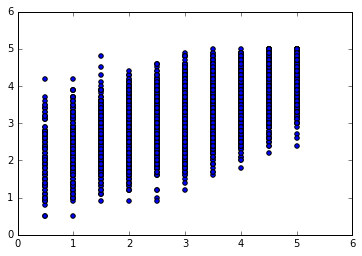

In [86]:
plt.scatter(uSetOrigRatings, uSetAvgRatings)

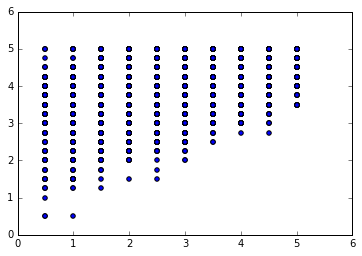

In [95]:
plt.scatter(uSetOrigRatings, uSetMajRatings)

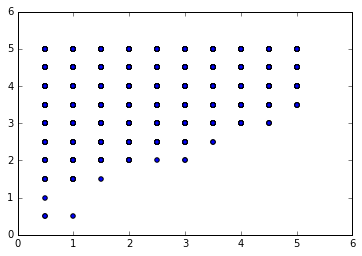

In [96]:
plt.scatter(uSetOrigRatings, uSetMaxRatings)

In [42]:
items

[928, 3578, 26965, 48516, 77846]

In [43]:
setRat

4.5

In [139]:
"""
nSetRatings:  32312
nUsers:  925  nItems:  13226
no. of uIRatings:  533772
no. of invalid users by TS:  52
Ratings not found for:  17
Total invalid users:  67
No. set ratings after filter:  29678

#matrix properties
nrows:  856 ncols:  12572
Average nnz cols:  37.6901845371
Average nnz rows:  553.552570093
NNZ:  473841.0
Sparsity:  0.0440305894125

Reading rating matrix 0 indexed...Reading...ml_set.train.lfs
No. of UserSets: 851
No. of sets: 27854
No. of items: 12314
max user: 855
max item: 12571
No. of train users: 851
nTrainSets: 27854
nTrainUsers: 851
nTrainItems: 12314

"""

'\nnSetRatings:  32312\nnUsers:  925  nItems:  13226\nno. of uIRatings:  533772\nno. of invalid users by TS:  52\nRatings not found for:  17\nTotal invalid users:  67\nNo. set ratings after filter:  29678\n\n#matrix properties\nnrows:  856 ncols:  12572\nAverage nnz cols:  37.6901845371\nAverage nnz rows:  553.552570093\nNNZ:  473841.0\nSparsity:  0.0440305894125\n\nReading rating matrix 0 indexed...Reading...ml_set.train.lfs\nNo. of UserSets: 851\nNo. of sets: 27854\nNo. of items: 12314\nmax user: 855\nmax item: 12571\nNo. of train users: 851\nnTrainSets: 27854\nnTrainUsers: 851\nnTrainItems: 12314\n\n'

In [150]:
uSetRatings = getSetRatings('db_filt_set_ratings.csv')
uiRatings = getUIRatings('db_ui_ratings.csv')

No. of sets:  29516
No. of u-i ratings:  510032


In [110]:
itemSetCount = {}
userSetCount = {}
for user, setRatings in uSetRatings.iteritems():
    if user not in userSetCount:
        userSetCount[user] = 0
    userSetCount[user] += len(setRatings)
    for setRating in setRatings:
        items = setRating[0]
        for item in items:
            if item not in itemSetCount:
                itemSetCount[item] = 0
            itemSetCount[item] += 1

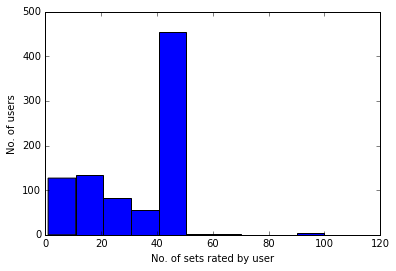

In [116]:
plt.hist(userSetCount.values())
plt.xlabel('No. of sets rated by user')
plt.ylabel('No. of users')

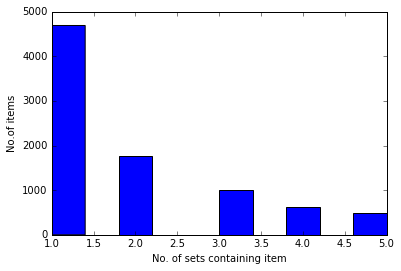

In [120]:
plt.hist(itemSetCount.values(), range=(1,5))
plt.xlabel('No. of sets containing item')
plt.ylabel('No.of items')

In [121]:
len(itemSetCount)

12598

In [122]:
len(userSetCount)

858

In [126]:
np.histogram(itemSetCount.values(), range=(1,5))

(array([4689,    0, 1766,    0,    0, 1007,    0,  627,    0,  481]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]))

In [133]:
uSetRatings = getSetRatings('db_set_ratings.csv')

In [135]:
invalU = []
with open('db_invalU_by_rat.txt', 'r') as f:
    for line in f:
        invalU.append(int(line.strip()))

In [161]:
uSetRatings = getSetRatings('db_filt_set_ratings.csv')
uiRatings = getUIRatings('db_ui_ratings.csv')

No. of sets:  29516
No. of u-i ratings:  510032


In [597]:
def rmse(l1, l2):
    a1 = np.asarray(l1)
    a2 = np.asarray(l2)
    n = len(l1)
    return np.sqrt(np.sum(np.square(a1 - a2))/n)

userOverPredCount  = {}
userUnderPredCount = {}
itemOverPredCount  = {}
itemUnderPredCount = {}
itemSetCount = {}

uOvPredSetRatings = {}
uUnderPredSetRatings = {}
uNeitherPredSetRatings = {}

def getUserSetsAvgRatings():
    origSetRatings = []
    origAvgSetRatings = []
    overPredCount = 0
    underPredcount = 0

    nOvPredSets = 0
    seOvPredSets = 0

    nUnPredSets = 0
    seUnPredSets = 0

    nNeitherSets = 0
    seNeitherSets = 0
    
    for user, itemsSetsNRat in uSetRatings.iteritems():
        if user not in uiRatings:
            print 'no ratings for ', user
            continue
        userOverPredCount[user]  = 0
        userUnderPredCount[user] = 0
        for itemSetNRat in itemsSetsNRat:
            items  = itemSetNRat[0]
            setRat = itemSetNRat[1]
            avgRat = 0.0
            for item in items:
                if item not in itemOverPredCount:
                    itemOverPredCount[item] = 0
                if item not in itemUnderPredCount:
                    itemUnderPredCount[item] = 0
                if item not in itemSetCount:
                    itemSetCount[item] = 0
                if item not in uiRatings[user]:
                    print 'Item: ', item, ' not found for user: ', user
                avgRat += uiRatings[user][item]
                itemSetCount[item] += 1
            avgRat = avgRat / len(items)
            
            if avgRat > setRat + 0.5:
                nOvPredSets += 1
                seOvPredSets += (avgRat - setRat)*(avgRat - setRat)
                if user not in uOvPredSetRatings:
                    uOvPredSetRatings[user] = []
                uOvPredSetRatings[user].append(itemSetNRat)
                overPredCount += 1
                userOverPredCount[user] += 1
                for item in items:
                    itemOverPredCount[item] += 1
            elif avgRat < setRat - 0.5:
                nUnPredSets += 1
                seUnPredSets += (avgRat - setRat)*(avgRat - setRat)
                if user not in uUnderPredSetRatings:
                    uUnderPredSetRatings[user] = []
                uUnderPredSetRatings[user].append(itemSetNRat)
                underPredcount += 1
                userUnderPredCount[user] += 1
                for item in items:
                    itemUnderPredCount[item] += 1
            else:
                nNeitherSets += 1
                seNeitherSets += (avgRat - setRat)*(avgRat - setRat)
                if user not in uNeitherPredSetRatings:
                    uNeitherPredSetRatings[user] = []
                uNeitherPredSetRatings[user].append(itemSetNRat)
                
            origSetRatings.append(setRat)
            origAvgSetRatings.append(avgRat)
    hexbin(origSetRatings, origAvgSetRatings, 'set ratings', 'average ratings')
    print 'rmse: ', rmse(origSetRatings, origAvgSetRatings)
    
    print 'nOvPredSets: ', nOvPredSets, ' ovPredRMSE: ', np.sqrt(seOvPredSets/nOvPredSets)
    print 'nUnPredSets: ', nUnPredSets, ' unPredRMSE: ', np.sqrt(seUnPredSets/nUnPredSets)
    print 'nNeitherSets: ', nNeitherSets, ' neitherSetsRMSE: ', np.sqrt(seNeitherSets/nNeitherSets)
    
    print 'overPredCount: ', overPredCount
    print 'underPredCount: ', underPredcount
    return (origSetRatings, origAvgSetRatings)

rmse:  0.597961482605
nOvPredSets:  5251  ovPredRMSE:  1.04726975886
nUnPredSets:  3934  unPredRMSE:  0.888905234838
nNeitherSets:  20331  neitherSetsRMSE:  0.287976561931
overPredCount:  5251
underPredCount:  3934


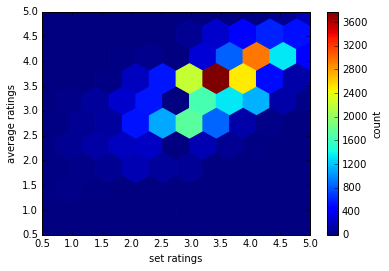

In [599]:
(origSetRatingsA, origAvgSetRatings) = getUserSetsAvgRatings()

In [332]:
def getUserSetsMajRatings():
    origSetRatings = []
    origMajSetRatings = []
    for user, itemsSetsNRat in uSetRatings.iteritems():
        if user not in uiRatings:
            print 'no ratings for ', user
            continue
        for itemSetNRat in itemsSetsNRat:
            items  = itemSetNRat[0]
            setRat = itemSetNRat[1]
            majRat = 0.0
            itemRatings = []
            for item in items:
                if item not in uiRatings[user]:
                    print 'Item: ', item, ' not found for user: ', user
                itemRatings.append((uiRatings[user][item], item))
            itemRatings.sort(reverse=True)
            for itemRating in itemRatings[:3]:
                item = itemRating[1]
                rating = itemRating[0]
                majRat += rating
            majRat = majRat/3
            origSetRatings.append(setRat)
            origMajSetRatings.append(majRat)
    hexbin(origSetRatings, origMajSetRatings, 'set ratings', 'Top 50pc average ratings')
    print 'rmse: ', rmse(origSetRatings, origMajSetRatings)
    return (origSetRatings, origMajSetRatings)

rmse:  0.8268938532


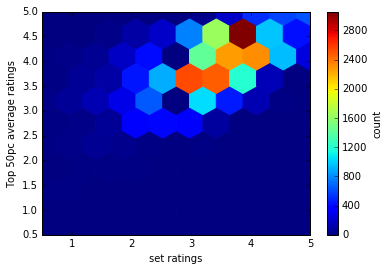

In [333]:
(origSetRatingsM, origMajSetRatings) = getUserSetsMajRatings()

In [334]:
def getUserSetsMaxRatings():
    origSetRatings = []
    origMaxSetRatings = []
    for user, itemsSetsNRat in uSetRatings.iteritems():
        if user not in uiRatings:
            print 'no ratings for ', user
            continue
        for itemSetNRat in itemsSetsNRat:
            items  = itemSetNRat[0]
            setRat = itemSetNRat[1]
            maxRat = 0.0
            itemRatings = []
            for item in items:
                if item not in uiRatings[user]:
                    print 'Item: ', item, ' not found for user: ', user
                itemRatings.append((uiRatings[user][item], item))
            itemRatings.sort(reverse=True)
            maxRat = itemRatings[0][0]
            origSetRatings.append(setRat)
            origMaxSetRatings.append(maxRat)
    hexbin(origSetRatings, origMaxSetRatings, 'set ratings', 'maximum rating')
    print 'rmse: ', rmse(origSetRatings, origMaxSetRatings)
    return (origSetRatings, origMaxSetRatings)

rmse:  1.19580298365


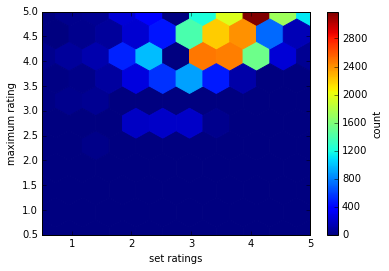

In [335]:
(origSetRatingsMx, origMaxSetRatings) = getUserSetsMaxRatings()

In [364]:

def hexbin(x, y, xlabel, ylabel, label='count'):
    plt.hexbin(x, y, gridsize=10, cmap=cm.jet, bins=None)
    plt.axis([0.5, 5, 0.5, 5])
    cb = plt.colorbar()
    cb.set_label(label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);

In [336]:
def getUserSetsMinRatings():
    origSetRatings = []
    origMinSetRatings = []
    for user, itemsSetsNRat in uSetRatings.iteritems():
        if user not in uiRatings:
            print 'no ratings for ', user
            continue
        for itemSetNRat in itemsSetsNRat:
            items  = itemSetNRat[0]
            setRat = itemSetNRat[1]
            minRat = 0.0
            itemRatings = []
            for item in items:
                if item not in uiRatings[user]:
                    print 'Item: ', item, ' not found for user: ', user
                itemRatings.append((uiRatings[user][item], item))
            itemRatings.sort()
            minRat = itemRatings[0][0]
            if (minRat < 0):
                print 'less than 0'
            origSetRatings.append(setRat)
            origMinSetRatings.append(minRat)
    hexbin(origSetRatings, origMinSetRatings, 'set ratings', 'minimum rating')
    print 'rmse: ', rmse(origSetRatings, origMinSetRatings)
    return (origSetRatings, origMinSetRatings)

rmse:  1.32053980737


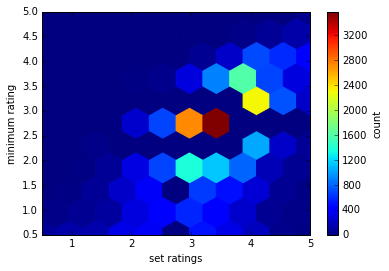

In [337]:
(origSetRatingsMn, origMinSetRatings) = getUserSetsMinRatings()

In [347]:
setRatings = []
for user, setNRatings in uSetRatings.iteritems():
    for setRating in setNRatings:
        setRatings.append(setRating[1])

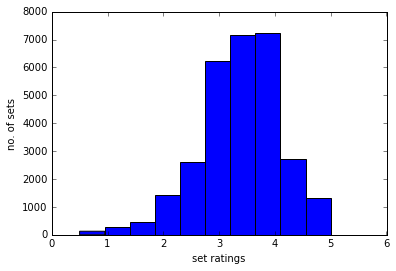

In [257]:
plt.hist(setRatings)
plt.xlabel('set ratings')
plt.ylabel('no. of sets')

In [348]:
len(setRatings), len(uSetRatings)

(29516, 854)

In [344]:
def getUserSetsSigmRatings():
    origSetSigmRatings = []
    avgSigmRatings = []
    for user, itemsSetsNRat in uSetRatings.iteritems():
        if user not in uiRatings:
            print 'no ratings for ', user
            continue
        uAvgRat = 0.0
        uRatcount = 0.0
        for item, rating in uiRatings[user].iteritems():
            uAvgRat += rating
            uRatcount += 1
        uAvgRat = uAvgRat / uRatcount
        uAvgRat = 3
        for itemSetNRat in itemsSetsNRat:
            items  = itemSetNRat[0]
            setRat = itemSetNRat[1]
            avgRat = 0.0
            itemRatings = []
            for item in items:
                if item not in uiRatings[user]:
                    print 'Item: ', item, ' not found for user: ', user
                avgRat += uiRatings[user][item]
            avgRat = avgRat/len(items)
            origSetSigmRatings.append(float(setRat)/5)
            avgSigmRatings.append(1.0/(1 + np.exp(-1.0*(avgRat - uAvgRat))))
    hexbin(origSetSigmRatings, avgSigmRatings, 'set scaled ratings', 'sigmoid rating with shift of 3')
    print 'rmse: ', rmse(origSetSigmRatings, avgSigmRatings)
    return (origSetSigmRatings, avgSigmRatings)

rmse:  0.141977907805


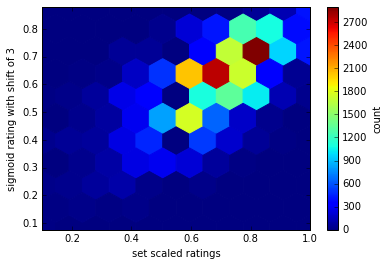

In [339]:
(origSetSigmRatings, avgSigmRatings) = getUserSetsSigmRatings()

rmse:  0.236691299059


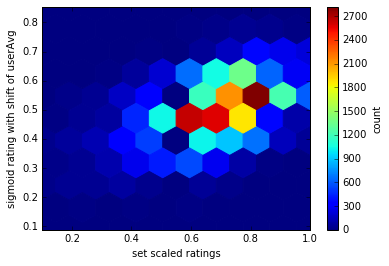

In [345]:
(origSetSigmRatings, avgSigmRatings) = getUserSetsSigmRatings()

In [301]:
ratings = []
for user, itemRatings in uiRatings.iteritems():
    for item, rating in itemRatings.iteritems():
        ratings.append(rating)

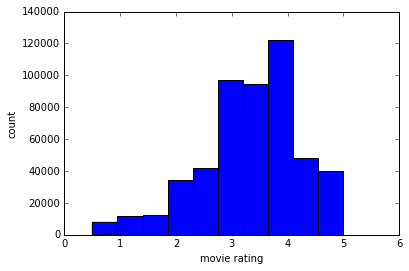

In [304]:
plt.hist(ratings)
plt.xlabel('movie rating')
plt.ylabel('count')

In [305]:
ratingCountFrmSets = {}
for user, setRatings in uSetRatings.iteritems():
    for setRating in setRatings:
        items = setRating[0]
        for item in items:
            rating = uiRatings[user][item]
            if rating not in ratingCountFrmSets:
                ratingCountFrmSets[rating] = 0
            ratingCountFrmSets[rating] += 1

In [306]:
ratingCountFrmSets

{0.5: 2653,
 1.0: 2981,
 1.5: 3151,
 2.0: 8060,
 2.5: 10354,
 3.0: 24570,
 3.5: 26866,
 4.0: 37186,
 4.5: 17091,
 5.0: 14668}

In [310]:
x = ratingCountFrmSets.keys()
x.sort()
y = [ratingCountFrmSets[k] for k in x]

In [311]:
x,y

([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
 [2653, 2981, 3151, 8060, 10354, 24570, 26866, 37186, 17091, 14668])

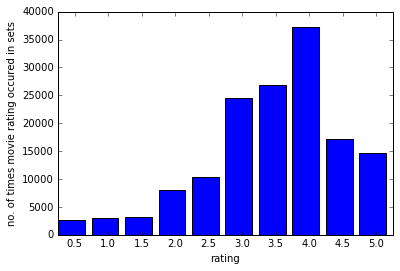

In [350]:
plt.bar(range(len(y)),y)
x_ticks = range(10)
for i in range(len(x_ticks)):
    x_ticks[i] = x_ticks[i] + 0.5
plt.xticks(x_ticks, (0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0))
plt.xlabel('rating')
plt.ylabel('no. of times movie rating occured in sets')

In [328]:
def compAvgRMSE():
    rmse = 0.0
    nSets = 0.0
    for user, setRatings in uSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            rating = setRating[1]
            avgRating = 0.0
            for item in items:
                avgRating += uiRatings[user][item]
            avgRating = avgRating/len(items)
            diff = rating - avgRating
            rmse += diff*diff
            nSets += 1
    print rmse, nSets
    rmse = np.sqrt(rmse/nSets)
    return rmse

In [329]:
compAvgRMSE()

10553.68 29516.0


0.59796148260530402

In [351]:
def getUserSetsMinRatings():
    origSetRatings = []
    origMinSetRatings = []
    for user, itemsSetsNRat in uSetRatings.iteritems():
        if user not in uiRatings:
            print 'no ratings for ', user
            continue
        for itemSetNRat in itemsSetsNRat:
            items  = itemSetNRat[0]
            setRat = itemSetNRat[1]
            minRat = 0.0
            itemRatings = []
            for item in items:
                if item not in uiRatings[user]:
                    print 'Item: ', item, ' not found for user: ', user
                itemRatings.append((uiRatings[user][item], item))
            itemRatings.sort()
            for itemRating in itemRatings[:3]:
                item = itemRating[1]
                rating = itemRating[0]
                minRat += rating
            minRat = minRat/3
            origSetRatings.append(setRat)
            origMinSetRatings.append(minRat)
    hexbin(origSetRatings, origMinSetRatings, 'set ratings', 'bottom 50pc average ratings')
    print 'rmse: ', rmse(origSetRatings, origMinSetRatings)
    return (origSetRatings, origMinSetRatings)

rmse:  0.759282128632


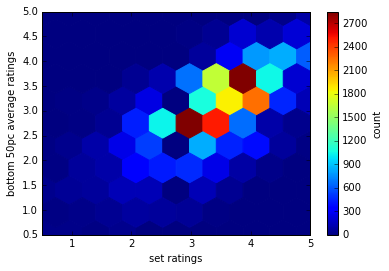

In [353]:
(origSetRatingsm, origMinSetRatings) = getUserSetsMinRatings()

In [367]:
avgUIRating = 0
nnz = 0
for user, itemRatings in uiRatings.iteritems():
    avgUIRating += np.sum(itemRatings.values())
    nnz += len(itemRatings)
avgUIRating = avgUIRating/nnz
print 'avgUIRating: ', avgUIRating

avgUIRating:  3.4018483154


In [368]:
avgSetRating = 0
nSets = 0
for user, setRatings in uSetRatings.iteritems():
    for setRating in setRatings:
        avgSetRating += setRating[1]
        nSets += 1
avgSetRating = avgSetRating/nSets
print 'avgSetRating: ', avgSetRating

avgSetRating:  3.44895988616


In [389]:
len(userOverPredCount)

854

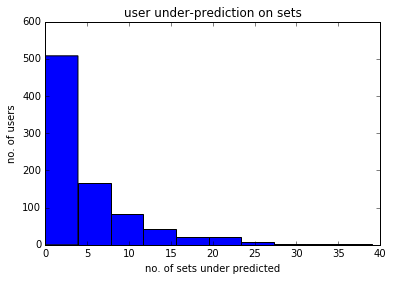

In [535]:
plt.hist(userUnderPredCount.values());
plt.xlabel('no. of sets under predicted')
plt.ylabel('no. of users')
plt.title('user under-prediction on sets')

(0, 600)

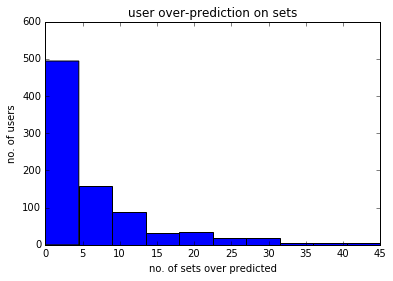

In [537]:
plt.hist(userOverPredCount.values());
plt.xlabel('no. of sets over predicted')
plt.ylabel('no. of users')
plt.title('user over-prediction on sets')
plt.ylim((0,600))

In [400]:
sum(userOverPredCount.values())

5251

In [401]:
sum(userUnderPredCount.values())

3934

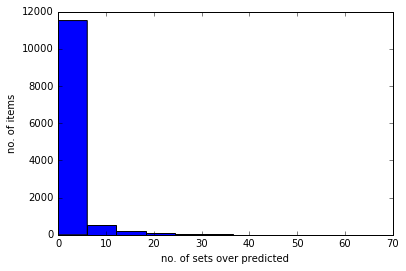

In [540]:
plt.hist(itemOverPredCount.values());
plt.xlabel('no. of sets over predicted')
plt.ylabel('no. of items')

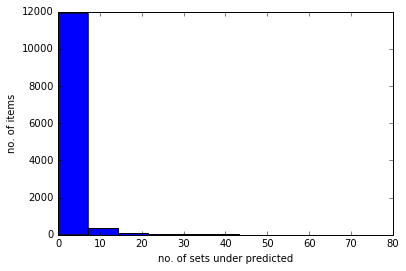

In [541]:
plt.hist(itemUnderPredCount.values());
plt.xlabel('no. of sets under predicted')
plt.ylabel('no. of items')

In [513]:
sum(itemOverPredCount.values()), sum(itemUnderPredCount.values())

(26255, 19670)

In [419]:
uSetRatings[276534]

[([55232, 67408, 72731, 111921, 117192], 4.0),
 ([2076, 37729, 44191, 56715, 86504], 3.0),
 ([7147, 8950, 38038, 58025, 78349], 4.0),
 ([5316, 32213, 48394, 60674, 64969], 2.5),
 ([745, 2010, 73017, 122904, 134130], 2.5),
 ([6754, 7438, 48997, 57274, 71135], 3.0),
 ([2193, 4226, 48045, 106782, 131050], 1.5),
 ([4367, 4389, 33004, 57640, 115617], 4.0),
 ([1527, 6350, 27619, 115713, 122896], 2.5),
 ([32898, 53000, 91974, 107737, 112515], 4.0),
 ([480, 8965, 94864, 107406, 122886], 2.0),
 ([6373, 8874, 26662, 83132, 90647], 1.5),
 ([4848, 5219, 71252, 81834, 108932], 1.5),
 ([2571, 2710, 6662, 42718, 63113], 3.0),
 ([2232, 59900, 64614, 72378, 109848], 3.0),
 ([1676, 3949, 6975, 45499, 151735], 4.5),
 ([42738, 59315, 64993, 71057, 107130], 4.0),
 ([593, 4886, 8973, 63859, 134853], 1.5),
 ([3168, 4993, 27478, 96655, 111360], 3.0),
 ([720, 3499, 3967, 4896, 69526], 4.0),
 ([1367, 1748, 32840, 59022, 59369], 3.0),
 ([1653, 3147, 5882, 51077, 69644], 3.0),
 ([1175, 4388, 81562, 103249, 116415

In [432]:
def avgSetRat(user, items):
    rat = 0.0
    for item in items:
        rat += uiRatings[user][item]
    rat = rat/len(items)
    return rat

In [447]:
def invOverPredSets(user):
    setRatings = uSetRatings[user]
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        predSetRat = avgSetRat(user, items)
        if abs(predSetRat - rating) > 2:
            s = ''
            for item in items:
                s += str(item) + ':' + str(uiRatings[user][item]) + ' '
            print rating, predSetRat, s
                

In [448]:
invOverPredSets(276534)

2.5 4.6 5316:4.0 32213:5.0 48394:4.5 60674:5.0 64969:4.5 
2.5 4.6 745:5.0 2010:5.0 73017:4.5 122904:4.5 134130:4.0 
1.5 4.8 2193:5.0 4226:5.0 48045:5.0 106782:4.0 131050:5.0 
2.0 4.3 480:4.5 8965:4.5 94864:5.0 107406:3.5 122886:4.0 
1.5 4.5 6373:3.5 8874:5.0 26662:5.0 83132:5.0 90647:4.0 
1.5 4.3 4848:5.0 5219:5.0 71252:3.5 81834:3.5 108932:4.5 
1.5 3.6 7153:5.0 8807:2.5 26258:5.0 44022:3.0 82461:2.5 
1.5 3.9 2105:2.5 47610:5.0 51086:5.0 70159:5.0 149322:2.0 
1.0 3.2 6333:2.0 59784:2.5 106489:5.0 112556:5.0 149406:1.5 
1.0 3.2 551:5.0 45186:2.5 53996:3.0 60408:0.5 94810:5.0 
0.5 3.7 1682:5.0 4223:3.0 63992:0.5 85412:5.0 98809:5.0 
0.5 2.7 5419:0.5 5481:0.5 6281:4.0 106487:4.5 114180:4.0 
0.5 3.4 5952:5.0 7099:5.0 8605:1.5 71379:5.0 72998:0.5 


In [570]:
def isSigDev(user, setRatings, setDev = 0.5, indivDev = 0.5):
    nDiffSets = 0
    for itemSetNRat in setRatings:
        items = itemSetNRat[0]
        rating = itemSetNRat[1]
        predSetRat = avgSetRat(user, items)
        if abs(predSetRat - rating) >= setDev:
            for item in items:
                if (abs(uiRatings[user][item] - predSetRat) >= indivDev):
                    nDiffSets += 1
                    break
    return nDiffSets
        
def is_rui_diffThanPred(user):
    setRatings = uSetRatings[user]
    nDiffSets = 0
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        predSetRat = avgSetRat(user, items)
        if abs(predSetRat-rating) >= 0.5:
            for item in items:
                if abs(uiRatings[user][item] - predSetRat) >= 0.5:
                    nDiffSets += 1
                    break
    return nDiffSets

In [459]:
uDiffSets = {}
for u in userOverPredCount.keys():
    nDiffSets = is_rui_diffThanPred(u)
    if nDiffSets > 0:
        uDiffSets[u] = nDiffSets

In [542]:
uOvPred5 = []
ovPredCt = 0
uOvPred5Sets = 0
uOvPredPc = {}
for u, nOvSet in userOverPredCount.iteritems():
    uOvPredPc[u] = float(nOvSet)/len(uSetRatings[u])
    if nOvSet >= 1:
        ovPredCt += 1
    if nOvSet >= 5:
        uOvPred5.append(u)
        uOvPred5Sets += nOvSet
        
uUnderPred5 = []
underPredCt = 0
uUnderPred5Sets = 0
uUnderPredPc = {}
for u, nUnSet in userUnderPredCount.iteritems():
    uUnderPredPc[u] = float(nUnSet)/len(uSetRatings[u])
    if nUnSet >= 1:
        underPredCt += 1
    if nUnSet >= 5:
        uUnderPred5.append(u)
        uUnderPred5Sets += nUnSet
        
print ovPredCt, uOvPred5Sets, underPredCt, uUnderPred5Sets

667 4555 638 3201


In [493]:
print len(uOvPred5), sum(userOverPredCount.values()), min(userOverPredCount.values()), max(userOverPredCount.values())
print len(uUnderPred5), sum(userUnderPredCount.values()), min(userUnderPredCount.values()), max(userUnderPredCount.values())

360 5251 0 45
298 3934 0 39


In [507]:
uOvDiffs = []
uOvDiffSets = 0
for user in uOvPred5:
    nDiffSets = is_rui_diffThanPred(user)
    uOvDiffSets += nDiffSets
    if nDiffSets > 0:
        uOvDiffs.append(user)

uUnDiffs = []
uUnDiffSets = 0
for user in uUnderPred5:
    nDiffSets = is_rui_diffThanPred(user)
    uUnDiffSets += nDiffSets
    if nDiffSets > 0:
        uUnDiffs.append(user)

In [457]:
avgItemRating = {}
itemCount     = {}
avgUserRating = {}
userCount     = {}
for user, itemRatings in uiRatings.iteritems():
    if user not in userCount:
        userCount[user] = 0
        avgUserRating[user] = 0
    for item, rating in itemRatings.iteritems():
        if item not in itemCount:
            itemCount[item] = 0
            avgItemRating[item] = 0
        userCount[user] += 1
        itemCount[item] += 1
        avgUserRating[user] += rating
        avgItemRating[item] += rating
for item in avgItemRating.keys():
    avgItemRating[item] = avgItemRating[item]/itemCount[item]
for user in avgUserRating.keys():
    avgUserRating[user] = avgUserRating[user]/userCount[user]

In [508]:
len(uOvDiffs), len(uUnDiffs), uOvDiffSets, uUnDiffSets

(322, 258, 2264, 1452)

In [479]:
invOverPredSets(90197)

1.0 3.2 273:4.0 317:1.5 7075:3.5 7841:4.0 8917:3.0 
0.5 3.5 1175:4.0 5740:1.5 7123:5.0 7481:3.5 53464:3.5 
0.5 3.2 410:4.0 1517:4.0 7001:0.5 48394:3.5 106072:4.0 


In [464]:
invOverPredSets(259564)

2.0 4.1 3275:4.5 5464:5.0 8874:4.5 45722:3.0 56171:3.5 
0.5 3.1 480:3.0 923:2.0 50872:3.0 55442:3.0 111443:4.5 
1.5 3.6 1961:3.0 33493:3.5 41566:2.5 44555:5.0 98809:4.0 
1.5 3.6 260:4.5 1348:2.5 3578:4.0 72998:4.5 106696:2.5 
0.5 3.3 837:2.5 3997:2.0 4975:4.0 8949:3.5 33794:4.5 
1.5 3.7 1293:2.0 2502:4.0 4993:5.0 7373:3.5 41997:4.0 
1.5 3.9 2571:5.0 48516:4.5 56869:4.0 99114:2.0 134853:4.0 


In [517]:
itemOvPred10 = []
itemOvPredCt = 0
itemOvPred10Sets = 0
for item, nOvSet in itemOverPredCount.iteritems():
    if nOvSet >= 1:
        itemOvPredCt += 1
    if nOvSet >= 10:
        itemOvPred10.append(item)
        itemOvPred10Sets += nOvSet
        
itemUnderPred10 = []
itemUnderPredCt = 0
itemUnderPred10Sets = 0
for item, nUnSet in itemUnderPredCount.iteritems():
    if nUnSet >= 1:
        itemUnderPredCt += 1
    if nUnSet >= 10:
        itemUnderPred10.append(item)
        itemUnderPred10Sets += nUnSet
        
print itemOvPredCt, len(itemOvPred10), itemOvPred10Sets, itemUnderPredCt, len(itemUnderPred10), itemUnderPred10Sets

6339 668 12790 5227 480 8829


In [525]:
itemOvPredPc = {}
itemUnderPredPc = {}
for item in itemSetCount.keys():
    pc = float(itemOverPredCount[item])/float(itemSetCount[item])
    itemOvPredPc[item] = pc
    pc = float(itemUnderPredCount[item])/float(itemSetCount[item])
    itemUnderPredPc[item] = pc

In [533]:
for item, pc in itemOvPredPc.iteritems():
    if pc > 0.5 and itemSetCount[item] > 5:
        print item, avgItemRating[item]

276 2.61538461538
308 3.76582278481
33171 3.65217391304
943 3.59259259259
1598 3.08333333333
1603 2.79166666667
1648 3.11363636364
5572 3.07352941176
3799 2.22
4056 3.19512195122
135137 2.59836065574
4255 2.03333333333
5316 3.35714285714
6970 3.70454545455
40148 3.01315789474
7560 3.81707317073
8183 3.77586206897
48319 3.09523809524
53161 3.15
53468 3.4
86487 3.525
86628 3.38461538462
92008 2.7972972973
27423 4.22222222222
62155 3.06790123457


In [534]:
for item, pc in itemUnderPredPc.iteritems():
    if pc > 0.5 and itemSetCount[item] > 5:
        print item, avgItemRating[item]

2153 1.95
4380 3.66129032258
81417 2.39285714286
50923 3.19230769231
101997 1.825


In [573]:
ovPredUsersByPc = []
netOverPredSets = 0
for user, pc in uOvPredPc.iteritems():
    if pc > 0.25 and len(uSetRatings[user]) > 4:
        ovPredUsersByPc.append(user)
        netOverPredSets += userOverPredCount[user]
        
underPredUsersByPc = []
netUnderPredSets = 0
for user, pc in uUnderPredPc.iteritems():
    if pc > 0.25 and len(uSetRatings[user]) > 4:
        underPredUsersByPc.append(user)
        netUnderPredSets += userUnderPredCount[user]
print 'ovPredUsersByPc: ', len(ovPredUsersByPc), netOverPredSets, ' underPredUsersPc: ', len(underPredUsersByPc), netUnderPredSets

ovPredUsersByPc:  212 3347  underPredUsersPc:  148 1946


In [577]:
uOvDiffs = []
uOvDiffSets = 0
for user in ovPredUsersByPc:
    nDiffSets = isSigDev(user, uOvPredSetRatings[user], 0.5, 1)
    uOvDiffSets += nDiffSets
    if nDiffSets > 0:
        uOvDiffs.append(user)

uUnDiffs = []
uUnDiffSets = 0
for user in underPredUsersByPc:
    nDiffSets = isSigDev(user, uUnderPredSetRatings[user], 0.5, 1)
    uUnDiffSets += nDiffSets
    if nDiffSets > 0:
        uUnDiffs.append(user)

In [578]:
len(uOvDiffs), uOvDiffSets, len(uUnDiffs), uUnDiffSets

(188, 2096, 137, 1393)

In [572]:
len(uOvDiffs), uOvDiffSets, len(uUnDiffs), uUnDiffSets

(68, 1415, 30, 446)

In [579]:
sum(userOverPredCount.values()), sum(userUnderPredCount.values())

(5251, 3934)

In [580]:
def seSets(user, setRatings):
    nSets = 0.0
    se = 0.0
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        predSetRat = avgSetRat(user, items)
        diff = predSetRat - rating
        se += diff*diff
        nSets += 1
    return (se, nSets)

se = 0
nsets = 0
for user, setRatings in uOvPredSetRatings.iteritems():
    (uSe, uNSets) = seSets(user, setRatings)
    se += uSe
    nsets += uNSets
print 'RMSE ovPredSets: ', np.sqrt(se/nsets)

se = 0
nsets = 0
for user, setRatings in uUnderPredSetRatings.iteritems():
    (uSe, uNSets) = seSets(user, setRatings)
    se += uSe
    nsets += uNSets
print 'RMSE unPredSets: ', np.sqrt(se/nsets)

RMSE ovPredSets:  1.04726975886
RMSE unPredSets:  0.888905234838


In [611]:
#go through over predicted sets and find gap between
#lowest rated item and others
def gapLowNOthers(user, itemsNRat):
    items = itemsNRat[0]
    rating = itemsNRat[1]
    predSetRat = avgSetRat(user, items)
    itemRatings = []
    for item in items:
        itemRatings.append((uiRatings[user][item], item))
    itemRatings.sort()
    loRat= itemRatings[0][0]
    avgRat = 0
    for itemRating in itemRatings[1:]:
        avgRat += itemRating[0]
    avgRat = avgRat / 4
    return abs(loRat - avgRat)

#two lowest rated item and others
def gap2LowNOthers(user, itemsNRat):
    items = itemsNRat[0]
    rating = itemsNRat[1]
    predSetRat = avgSetRat(user, items)
    itemRatings = []
    for item in items:
        itemRatings.append((uiRatings[user][item], item))
    itemRatings.sort()
    loRat = itemRatings[0][0] + itemRatings[1][0]
    loRat = loRat/2
    avgRat = 0
    for itemRating in itemRatings[2:]:
        avgRat += itemRating[0]
    avgRat = avgRat / 3
    return abs(loRat - avgRat)

def gapLowNMedian(user, itemsNRat):
    items = itemsNRat[0]
    rating = itemsNRat[1]
    predSetRat = avgSetRat(user, items)
    itemRatings = []
    for item in items:
        itemRatings.append((uiRatings[user][item], item))
    itemRatings.sort()
    loRat= itemRatings[0][0]
    medRat = itemRatings[2][0]
    return abs(loRat - medRat)

In [614]:
avgGapLowNOthers = 0
avgGap2LowNOthers = 0
avgGapLowNMed = 0
count = 0
for user, setRatings in uOvPredSetRatings.iteritems():
    for setRating in setRatings:
        avgGapLowNOthers += gapLowNOthers(user, setRating)
        avgGap2LowNOthers += gap2LowNOthers(user, setRating)
        avgGapLowNMed += gapLowNMedian(user, setRating)
        count += 1
avgGapLowNOthers = avgGapLowNOthers/count
avgGap2LowNOthers = avgGap2LowNOthers/count
avgGapLowNMed = avgGapLowNMed/count
print avgGapLowNOthers, avgGap2LowNOthers, avgGapLowNMed

1.36171681584 1.22517933092 1.16968196534


In [618]:
avgGapLowNOthers = 0
avgGap2LowNOthers = 0
avgGapLowNMed = 0
count = 0
for user, setRatings in uNeitherPredSetRatings.iteritems():
    for setRating in setRatings:
        avgGapLowNOthers += gapLowNOthers(user, setRating)
        avgGap2LowNOthers += gap2LowNOthers(user, setRating)
        avgGapLowNMed += gapLowNMedian(user, setRating)
        count += 1
avgGapLowNOthers = avgGapLowNOthers/count
avgGap2LowNOthers = avgGap2LowNOthers/count
avgGapLowNMed = avgGapLowNMed/count
print avgGapLowNOthers, avgGap2LowNOthers, avgGapLowNMed

1.24580689587 1.12048103881 1.06440903054


In [612]:
avgGapLowNOthers = 0
avgGapLowNMed = 0
avgGap2LowNOthers = 0
count = 0
for user, setRatings in uUnderPredSetRatings.iteritems():
    for setRating in setRatings:
        avgGapLowNOthers += gapLowNOthers(user, setRating)
        avgGap2LowNOthers += gap2LowNOthers(user, setRating)
        avgGapLowNMed += gapLowNMedian(user, setRating)
        count += 1
avgGapLowNOthers = avgGapLowNOthers/count
avgGap2LowNOthers = avgGap2LowNOthers/count
avgGapLowNMed = avgGapLowNMed/count
print avgGapLowNOthers, avgGap2LowNOthers, avgGapLowNMed

1.54728012201 1.41029062871 1.32651245552


In [610]:
def gapTopNOthers(user, itemsNRat):
    items = itemsNRat[0]
    rating = itemsNRat[1]
    predSetRat = avgSetRat(user, items)
    itemRatings = []
    for item in items:
        itemRatings.append((uiRatings[user][item], item))
    itemRatings.sort(reverse=True)
    loRat= itemRatings[0][0]
    avgRat = 0
    for itemRating in itemRatings[1:]:
        avgRat += itemRating[0]
    avgRat = avgRat / 4
    return abs(loRat - avgRat)

#two lowest rated item and others
def gap2TopNOthers(user, itemsNRat):
    items = itemsNRat[0]
    rating = itemsNRat[1]
    predSetRat = avgSetRat(user, items)
    itemRatings = []
    for item in items:
        itemRatings.append((uiRatings[user][item], item))
    itemRatings.sort(reverse=True)
    loRat = itemRatings[0][0] + itemRatings[1][0]
    loRat = loRat/2
    avgRat = 0
    for itemRating in itemRatings[2:]:
        avgRat += itemRating[0]
    avgRat = avgRat / 3
    return abs(loRat - avgRat)

def gapTopNMedian(user, itemsNRat):
    items = itemsNRat[0]
    rating = itemsNRat[1]
    predSetRat = avgSetRat(user, items)
    itemRatings = []
    for item in items:
        itemRatings.append((uiRatings[user][item], item))
    itemRatings.sort(reverse=True)
    loRat= itemRatings[0][0]
    medRat = itemRatings[2][0]
    return abs(loRat - medRat)

In [615]:
avgGapTopNOthers = 0
avgGap2TopNOthers = 0
avgGapTopNMed  = 0
count = 0
for user, setRatings in uOvPredSetRatings.iteritems():
    for setRating in setRatings:
        avgGapTopNOthers += gapTopNOthers(user, setRating)
        avgGap2TopNOthers += gap2TopNOthers(user, setRating)
        avgGapTopNMed += gapTopNMedian(user, setRating)
        count += 1
avgGapTopNOthers = avgGapTopNOthers/count
avgGap2TopNOthers = avgGap2TopNOthers/count
avgGapTopNMed = avgGapTopNMed/count
print avgGapTopNOthers, avgGap2TopNOthers, avgGapTopNMed

1.13792610931 1.15825557037 0.830032374786


In [616]:
avgGapTopNOthers = 0
avgGap2TopNOthers = 0
avgGapTopNMed  = 0
count = 0
for user, setRatings in uUnderPredSetRatings.iteritems():
    for setRating in setRatings:
        avgGapTopNOthers += gapTopNOthers(user, setRating)
        avgGap2TopNOthers += gap2TopNOthers(user, setRating)
        avgGapTopNMed += gapTopNMedian(user, setRating)
        count += 1
avgGapTopNOthers = avgGapTopNOthers/count
avgGap2TopNOthers = avgGap2TopNOthers/count
avgGapTopNMed = avgGapTopNMed/count
print avgGapTopNOthers, avgGap2TopNOthers, avgGapTopNMed

1.31574097611 1.33638366379 0.963904422979


In [617]:
avgGapTopNOthers = 0
avgGap2TopNOthers = 0
avgGapTopNMed  = 0

count = 0
for user, setRatings in uNeitherPredSetRatings.iteritems():
    for setRating in setRatings:
        avgGapTopNOthers += gapTopNOthers(user, setRating)
        avgGap2TopNOthers += gap2TopNOthers(user, setRating)
        avgGapTopNMed += gapTopNMedian(user, setRating)
        count += 1
avgGapTopNOthers = avgGapTopNOthers/count
avgGap2TopNOthers = avgGap2TopNOthers/count
avgGapTopNMed = avgGapTopNMed/count

print avgGapTopNOthers, avgGap2TopNOthers, avgGapTopNMed

1.05480546948 1.06401144394 0.776080861738


In [619]:
uSetCount = {}
for u, setRatings in uSetRatings.iteritems():
    uSetCount[u] = len(setRatings)

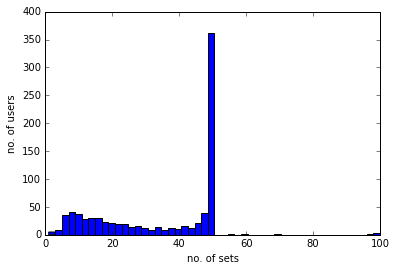

In [625]:
plt.hist(uSetCount.values(), bins=50);
plt.xlabel('no. of sets')
plt.ylabel('no. of users')

In [624]:
min(uSetCount.values()), np.average(uSetCount.values()), max(uSetCount.values())

(1, 34.562060889929739, 100)

In [719]:
def getSetEntropy(user, items):
    entropy = 0.0
    bins = [0 for i in range(5)]
    for i in range(len(items)):
        item = items[i]
        rating = uiRatings[user][item]
        if rating >= 0 and rating <= 1:
            bins[0] += 1
        elif rating > 1 and rating <= 2:
            bins[1] += 1
        elif rating > 2 and rating <= 3:
            bins[2] += 1
        elif rating > 3 and rating <= 4:
            bins[3] += 1
        elif rating > 4 and rating <= 5:
            bins[4] += 1
    for ct in bins:
        ct = float(ct)
        if ct > 0:
            entropy += -1.0 * ct/5 * np.log(ct/5)
    return entropy

def getSetsEntropy(userSetRatings):
    nSets = 0
    setsEntropy = []
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            setsEntropy.append(getSetEntropy(user, items))
            nSets += 1
    return setsEntropy

def avgPairwiseSim(user, items):
    avgSim = 0.0
    nPairs = 0
    for i in range(len(items)):
        for j in range(i+1, len(items)):
            diff = uiRatings[user][items[i]] - uiRatings[user][items[j]]
            avgSim += diff*diff
            nPairs += 1
    avgSim = np.sqrt(avgSim / nPairs)
    return avgSim

def getPairwiseSim(uSetRatings):
    nSets = 0
    pSim  = 0.0
    for user, setRatings in uSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            rating = setRating[1]
            pSim += avgPairwiseSim(user, items)
            nSets += 1
    return pSim/nSets

def getPairwiseSims(uSetRatings):
    nSets = 0
    pSims  = []
    for user, setRatings in uSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            rating = setRating[1]
            pSims.append(avgPairwiseSim(user, items))
            nSets += 1
    return pSims

In [772]:
print 'overPred psim: ', getPairwiseSim(uOvPredSetRatings),
print 'underPred psim: ', getPairwiseSim(uUnderPredSetRatings)
print 'neither psim: ', getPairwiseSim(uNeitherPredSetRatings)

overPred psim:  1.1799223863 underPred psim:  1.34981590387
neither psim:  1.08411048827


In [641]:
uSetPc = {}
for user, setRatings in uSetRatings.iteritems():
    nSets = len(setRatings)
    nOvPredSets = 0
    nUnderPredSets = 0
    nNeitherPredSets = 0
    if user in uOvPredSetRatings:
        nOvPredSets = float(len(uOvPredSetRatings[user]))
    if user in uUnderPredSetRatings:
        nUnderPredSets = float(len(uUnderPredSetRatings[user]))
    if user in uNeitherPredSetRatings:
        nNeitherPredSets = float(len(uNeitherPredSetRatings[user]))
    if nOvPredSets + nUnderPredSets + nNeitherPredSets != nSets:
        print 'No. of sets mismatch for', user
    uSetPc[user] = (nOvPredSets/nSets, nUnderPredSets/nSets, nNeitherPredSets/nSets)

In [642]:
ovPredPc = []
unPredPc = []
neitherPredPc = []
for user, pcs in uSetPc.iteritems():
    ovPredPc.append(pcs[0])
    unPredPc.append(pcs[1])
    neitherPredPc.append(pcs[2])

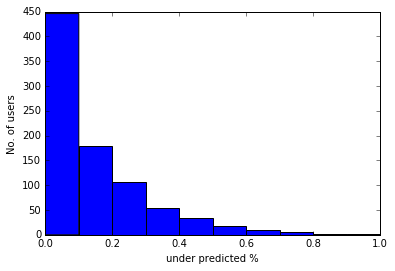

In [646]:
plt.hist(unPredPc)
plt.xlabel('under predicted %')
plt.ylabel('No. of users')

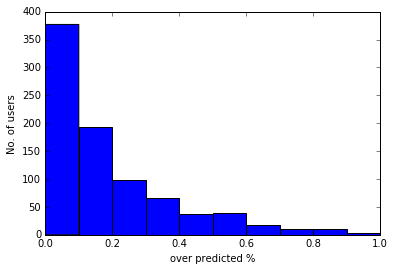

In [647]:
plt.hist(ovPredPc)
plt.xlabel('over predicted %')
plt.ylabel('No. of users')

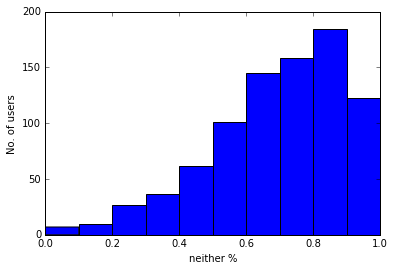

In [652]:
plt.hist(neitherPredPc)
plt.xlabel('neither %')
plt.ylabel('No. of users')

In [653]:
f_val, p_val = stats.f_oneway(treatment1, treatment2, treatment3)

In [720]:
overPredPSims = getPairwiseSims(uOvPredSetRatings)
overPredEn = getSetsEntropy(uOvPredSetRatings)
underPredPSims = getPairwiseSims(uUnderPredSetRatings)
underPredEn = getSetsEntropy(uUnderPredSetRatings)
neitherPredPSims = getPairwiseSims(uNeitherPredSetRatings)
neitherPredEn = getSetsEntropy(uNeitherPredSetRatings)

In [656]:
f_val, p_val = stats.f_oneway(overPredPSims, underPredSims, neitherPredSims)

In [665]:
print f_val, p_val
"http://www.scipy-lectures.org/packages/statistics/index.html#hypothesis-testing-comparing-two-groups"

400.520044201 2.37178923268e-172


'http://www.scipy-lectures.org/packages/statistics/index.html#hypothesis-testing-comparing-two-groups'

In [661]:
stats.ttest_ind(overPredPSims, underPredPSims)

Ttest_indResult(statistic=-13.668707960853322, pvalue=4.0279620295625119e-42)

In [662]:
stats.ttest_ind(overPredPSims, neitherPredPSims)

Ttest_indResult(statistic=11.420801127143234, pvalue=3.8950098428977017e-30)

In [664]:
stats.ttest_ind(overPredPSims, overPredPSims)

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [666]:
itemSetCount = {}
for user, setRatings in uSetRatings.iteritems():
    for setRating in setRatings:
        items = setRating[0]
        for item in items:
            if item not in itemSetCount:
                itemSetCount[item] = 0
            itemSetCount[item] += 1
            

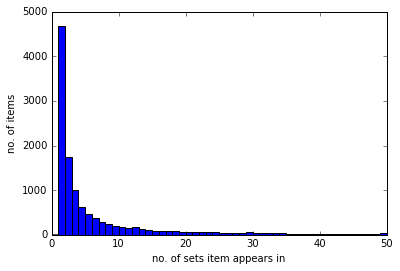

In [773]:
plt.hist(itemSetCount.values(),bins=50, range=(0,50));
plt.xlabel('no. of sets item appears in')
plt.ylabel('no. of items')

In [672]:
def getItemNAvgSetratings(userSetRatings):
    itemSetRatDist = {}
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            rating = setRating[1]
            avgRating = avgSetRat(user, items)
            for item in items:
                itemRating = uiRatings[user][item]
                if item not in itemSetRatDist:
                    itemSetRatDist[item] = {itemRating: [0.0, 0.0, 0.0]}
                elif itemRating not in itemSetRatDist[item]:
                    itemSetRatDist[item][itemRating] = [0.0,0.0,0.0]
                itemSetRatDist[item][itemRating][0] += rating
                itemSetRatDist[item][itemRating][1] += avgRating
                itemSetRatDist[item][itemRating][2] += 1
    for item, itemRatDist in itemSetRatDist.iteritems():
        for itemRating in itemRatDist.keys():
            itemSetRatDist[item][itemRating][0] = itemSetRatDist[item][itemRating][0]/itemSetRatDist[item][itemRating][2]
            itemSetRatDist[item][itemRating][1] = itemSetRatDist[item][itemRating][1]/itemSetRatDist[item][itemRating][2]
    return itemSetRatDist

In [673]:
itemDist = getItemNAvgSetratings(uSetRatings)

In [674]:
itemDist.keys()[:5]
    

[98304, 1, 2, 3, 4]

In [677]:
itemDist[2]

{1.5: [3.25, 3.15, 4.0],
 2.0: [2.8125, 2.7875, 8.0],
 2.5: [2.909090909090909, 3.0545454545454542, 11.0],
 3.0: [3.38, 3.4, 25.0],
 3.5: [3.52, 3.556, 25.0],
 4.0: [3.5, 3.6578947368421053, 19.0],
 4.5: [4.166666666666667, 3.8333333333333335, 3.0],
 5.0: [4.0, 4.15, 4.0]}

In [712]:
ovItems = []
unItems = []
for item in itemDist.keys():
    totalSets = 0
    ovSets = 0
    unSets = 0
    for rating, setRats in itemDist[item].iteritems():
        setRat = setRats[0]
        avgRat = setRats[1]
        nSets = setRats[2]
        totalSets += nSets
        if avgRat - setRat > 0.5:
            ovSets += nSets
        elif avgRat - setRat < -0.5:
            unSets += nSets
    if totalSets > 4 and float(ovSets)/float(totalSets) > 0.5:
        ovItems.append(item)
    if totalSets > 4 and float(unSets)/float(totalSets) > 0.5:
        unItems.append(item)

In [713]:
len(ovItems), len(unItems)

(100, 25)

In [715]:
for item in ovItems[:10]:
    nSets = 0
    for rating, setRats in itemDist[item].iteritems():
        nSets += setRats[2]
    if nSets > 5:
        print item, itemDist[item]

267 {3.5: [3.5, 3.9, 1.0], 1.0: [1.5, 1.9, 1.0], 2.0: [4.0, 3.4, 1.0], 3.0: [3.1666666666666665, 3.6999999999999997, 3.0], 2.5: [3.0, 3.6, 1.0]}
276 {2.5: [2.5, 3.1, 3.0], 3.5: [3.0, 4.0, 2.0], 2.0: [3.5, 3.55, 2.0]}
33171 {3.5: [2.0, 3.65, 2.0], 2.5: [4.0, 3.7, 1.0], 2.0: [4.0, 3.1, 1.0], 3.0: [2.1666666666666665, 3.1333333333333333, 3.0], 4.0: [3.0, 3.4, 1.0], 5.0: [5.0, 4.5, 1.0]}
532 {0.5: [5.0, 3.2, 1.0], 3.5: [3.0, 3.3, 1.0], 3.0: [2.5, 3.0, 1.0], 4.0: [2.375, 3.5, 4.0]}
565 {3.5: [3.25, 3.85, 2.0], 2.0: [3.0, 2.0, 1.0], 3.0: [5.0, 3.6, 1.0], 5.0: [2.5, 3.45, 2.0]}
92938 {0.5: [2.1666666666666665, 2.6999999999999997, 3.0], 2.5: [3.0, 3.6, 1.0], 3.0: [4.0, 3.4, 1.0], 3.5: [3.5, 3.8, 1.0]}
991 {2.5: [3.0, 2.6, 1.0], 4.5: [5.0, 4.5, 1.0], 3.0: [2.75, 2.85, 2.0], 4.0: [2.6666666666666665, 3.6666666666666665, 3.0], 3.5: [3.0, 3.55, 2.0]}


In [711]:
for item in unItems[:10]:
    nSets = 0
    for rating, setRats in itemDist[item].iteritems():
        nSets += setRats[2]
    print item, itemDist[item]

2034 {1.5: [2.0, 2.5, 1.0], 2.5: [4.0, 3.3, 1.0], 2.0: [3.5, 2.8, 1.0], 3.0: [4.25, 3.4000000000000004, 2.0]}
79463 {3.5: [4.0, 3.15, 2.0], 2.5: [4.0, 3.4, 1.0], 2.0: [3.0, 2.1, 1.0], 3.0: [2.5, 3.1, 1.0]}
103299 {0.5: [3.5, 2.9, 1.0], 3.5: [4.5, 3.4, 1.0], 4.0: [5.0, 3.8, 1.0], 4.5: [4.0, 4.0, 1.0], 2.5: [3.5, 2.8, 1.0]}


In [707]:
itemDist[1]

{0.5: [2.5, 2.6, 1.0],
 1.0: [2.4444444444444446, 2.844444444444445, 9.0],
 1.5: [3.25, 3.1750000000000003, 4.0],
 2.0: [2.875, 3.0874999999999995, 8.0],
 2.5: [3.2142857142857144, 3.228571428571428, 14.0],
 3.0: [3.223684210526316, 3.392105263157894, 38.0],
 3.5: [3.5526315789473686, 3.4473684210526314, 38.0],
 4.0: [3.664383561643836, 3.679452054794519, 73.0],
 4.5: [3.7906976744186047, 3.9790697674418603, 43.0],
 5.0: [3.6973684210526314, 4.11578947368421, 38.0]}

In [721]:
overPredPSims = getPairwiseSims(uOvPredSetRatings)
overPredEn = getSetsEntropy(uOvPredSetRatings)
underPredPSims = getPairwiseSims(uUnderPredSetRatings)
underPredEn = getSetsEntropy(uUnderPredSetRatings)
neitherPredPSims = getPairwiseSims(uNeitherPredSetRatings)
neitherPredEn = getSetsEntropy(uNeitherPredSetRatings)

In [724]:
np.average(overPredEn), np.average(underPredEn), np.average(neitherPredEn)

(0.85040048318953854, 0.91616024382288974, 0.81135155352229804)

In [771]:
np.average(overPredPSims), np.average(underPredPSims), np.average(neitherPredPSims)

(1.1799223862967847, 1.349815903867573, 1.084110488268722)

In [726]:
stats.ttest_ind(overPredEn, neitherPredEn)

Ttest_indResult(statistic=7.8930620180848745, pvalue=3.0661213794393644e-15)

In [728]:
stats.ttest_ind(underPredEn, neitherPredEn)

Ttest_indResult(statistic=18.84139879952291, pvalue=1.2599599705852004e-78)

In [729]:
def ratingDist(userSetRatings):
    ratCount = {}
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            rating = setRating[1]
            for item in items:
                itemRating = uiRatings[user][item]
                if itemRating not in ratCount:
                    ratCount[itemRating] = 0
                ratCount[itemRating] += 1
    return ratCount

In [731]:
ovPredRatDist = ratingDist(uOvPredSetRatings)

In [732]:
ovPredRatDist

{0.5: 548,
 1.0: 573,
 1.5: 525,
 2.0: 1479,
 2.5: 1716,
 3.0: 4194,
 3.5: 4480,
 4.0: 6861,
 4.5: 3009,
 5.0: 2870}

In [733]:
unPredRatDist = ratingDist(uUnderPredSetRatings)

In [734]:
unPredRatDist

{0.5: 681,
 1.0: 727,
 1.5: 621,
 2.0: 1449,
 2.5: 1517,
 3.0: 3374,
 3.5: 3296,
 4.0: 4457,
 4.5: 1855,
 5.0: 1693}

In [765]:
def getEntropySetsRatingGr8Pc(pcThresh = 0.5):
    #users and its sets
    filtUOvPredSets = {}
    #no. of over pred sets by the user
    nOvPredSets = 0
    
    filtUUnPredSets = {}
    nUnPredSets = 0
    filtUNeitherPredSets = {}
    nNeitherPredSets = 0
    for user, setRatings in uSetRatings.iteritems():
        if uSetPc[user][0] > pcThresh:
            filtUOvPredSets[user] = setRatings
            nOvPredSets += len(uOvPredSetRatings[user])
        if uSetPc[user][1] > pcThresh:
            filtUUnPredSets[user] = setRatings
            nUnPredSets += len(uUnderPredSetRatings[user])
        if uSetPc[user][2] > pcThresh:
            filtUNeitherPredSets[user] = setRatings
            nNeitherPredSets += len(uNeitherPredSetRatings[user])
    print 'overPredUsers: ', len(filtUOvPredSets), np.average(getSetsEntropy(filtUOvPredSets)), nOvPredSets 
    print 'underPredUsers: ', len(filtUUnPredSets), np.average(getSetsEntropy(filtUUnPredSets)), nUnPredSets
    print 'neitherPredUsers: ', len(filtUNeitherPredSets), np.average(getSetsEntropy(filtUNeitherPredSets)), nNeitherPredSets

In [766]:
getEntropySetsRatingGr8Pc(0.1)

overPredUsers:  450 0.848471284401 4749
underPredUsers:  383 0.86891635851 3353
neitherPredUsers:  846 0.832550177263 20326


In [767]:
getEntropySetsRatingGr8Pc(0.25)

overPredUsers:  216 0.856286920903 3355
underPredUsers:  150 0.890039024995 1948
neitherPredUsers:  822 0.82965569467 20180


In [768]:
getEntropySetsRatingGr8Pc(0.35)

overPredUsers:  141 0.86058522442 2553
underPredUsers:  88 0.898882963379 1259
neitherPredUsers:  792 0.827247251639 19916


In [769]:
getEntropySetsRatingGr8Pc(0.5)

overPredUsers:  72 0.868387849754 1500
underPredUsers:  30 0.911784053237 468
neitherPredUsers:  691 0.817655391823 18392


In [770]:
getEntropySetsRatingGr8Pc(0.75)

overPredUsers:  15 0.889444156532 386
underPredUsers:  4 0.927935611902 53
neitherPredUsers:  372 0.782004916019 10934
